# Replication of results for the HIV model - scalar QoI

This is a notebook to recreate the results of Section 8 of

W.N. Edeling, "On the deep active subspace method", SIAM/ASA Journal on Uncertainty Quantification, 2022.

Here we will apply the deep active subspace method [1] to an HIV model consisting of 7 coupled ordinary differential equations [2], with 27 uncertain input parameters, see the article above for more information.

This notebook contains the results for the scalar QoI case. For the vector-valued QoI, see `HIV_vector.ipynb`.

### Requirements

The Deep Active Subspace method is implemented in [EasySurrogate](https://github.com/wedeling/EasySurrogate). To install, simply uncomment the `!pip install` line below. Furthermore, `scipy`, `seaborn` and `pandas` are also required.

[1] Tripathy, R., & Bilionis, I. (2019, August). Deep active subspaces: A scalable method for high-dimensional uncertainty propagation. In International Design Engineering Technical Conferences and Computers and Information in Engineering Conference (Vol. 59179, p. V001T02A074). American Society of Mechanical Engineers.

[2] Loudon, T., & Pankavich, S. (2017). Mathematical analysis and dynamic active subspaces for a long term model of HIV. Mathematical Biosciences and Engineering, 14(3), 709-733.

[3] Constantine, P. G. (2014). A quick-and-dirty check for a one-dimensional active subspace. arXiv preprint arXiv:1402.3838.

In [1]:
#!pip install easysurrogate==0.18

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import easysurrogate as es
from scipy import linalg
import pandas as pd
import seaborn as sns

In [3]:
# select the seismic color scheme
plt.rcParams['image.cmap'] = 'seismic'

### EasySurrogate campaign

EasySurrogate's basic object is called a `campaign', which handles the data. 

In [4]:
# Create EasySurrogate campaign
campaign = es.Campaign()

### Load training data

Here we use the campaign to load the training data, which is precomputed and stored in the `my_samples.hdf5` file. We also load the model gradients from https://github.com/paulcon/as-data-sets/tree/master/HIV to compute the reference (original) active subspace.

In [5]:
##########################
# Generate training data #
##########################

# number of inputs
D = 27

# the times (in days) at which the HIV model was sampled
times = np.array([5, 15, 24, 38, 40, 45, 50, 55, 65, 90, 140, 500, 750,
                  1000, 1600, 1800, 2000, 2200, 2400, 2800, 3400])
T = times.size

# Use derivative data from https://github.com/paulcon/as-data-sets/tree/master/HIV
derivatives = pd.read_csv('./gradients.csv').values[:, 1:]
derivatives = derivatives.reshape([-1, T, D])

# Load HDF5  training data using the Campaign
data = campaign.load_hdf5_data(file_path='my_samples.hdf5')
# input parameters in [-1, 1]
params = data['inputs']
# output (T-cell counts at times)
samples = data['outputs']

# time index at which to construct an active subspace
I = -1
samples = samples[:, I].reshape([-1, 1])
derivatives = derivatives[:, I, :]
# scale the derivatives for consistency with the standardized ANN and DAS results
derivatives /= np.std(samples)

Loaded inputs
Loaded outputs


### Select $d$

We we select $d=1$, i.e. we are constructing a 1D active subspace.

In [6]:
########################################
# choose the active subspace dimension #
########################################
d = 1

### Train a (unconstrained) artificial neural network

We train a standard artificial neural network. The inputs are already normalized to lie within $[-1, 1]$, and we standardize the output.

In [7]:
ann_uc_surrogate = es.methods.ANN_Surrogate()
# train vanilla ANN. The input parameters are already scaled to [-1, 1], so no need to
# standardize these
ann_uc_surrogate.train(params, samples, 
                n_iter=10000, n_layers=4, n_neurons=100, test_frac = 0.1, 
                batch_size = 64, standardize_X=False, standardize_y=True)

Creating ANN_Surrogate Object
Creating Feature Engineering object
Using  900/1000 samples to train the ML model
done preparing data
Neural net parameters
Number of layers = 4
Number of features = 27
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'tanh', 'tanh', 'tanh', 'linear']
This neural network has 23101 weights.
Training Artificial Neural Network...
Batch 0 learning rate 0.001 loss: 1.3369322256353062
Batch 1000 learning rate 0.001 loss: 0.0004615564311320874
Batch 2000 learning rate 0.001 loss: 6.705210912347266e-05
Batch 3000 learning rate 0.001 loss: 0.0010006809738640843
Batch 4000 learning rate 0.001 loss: 6.235352477269046e-05
Batch 5000 learning rate 0.001 loss: 0.00011817674278648946
Batch 6000 learning rate 0.001 loss: 8.852322330578617e-05
Batch 7000 learning rate 0.001 loss: 6.376321318811768e-05
Batch 8000 learning rate 0.001 loss: 4.334388845747609e-05
Batch 9000 learning rate 0.001 loss: 6.5479943

### Compute the original active subspace of the unconstrained ANN

In [8]:
# Number of Monte Carlo samples
n_mc = params.shape[0]

# gradient matrix for the ANN
C_ann_uc = 0.0

ann_uc_samples = np.zeros(n_mc)
# compute the derivative of the neural net output for every input
for i, param in enumerate(params):
    # construct the C matrix
    df_dx = ann_uc_surrogate.derivative(param, norm=False)
    C_ann_uc += np.dot(df_dx, df_dx.T) / n_mc
    # store predictions for later
    ann_uc_samples[i] = ann_uc_surrogate.predict(param)

# Solve eigenproblem
eigvals_C_ann_uc, eigvecs_C_ann_uc = linalg.eigh(C_ann_uc)

# Sort the eigensolutions in the descending order of eigenvalues
order_ann_uc = eigvals_C_ann_uc.argsort()[::-1]
eigvals_C_ann_uc = eigvals_C_ann_uc[order_ann_uc]
eigvecs_C_ann_uc = eigvecs_C_ann_uc[:, order_ann_uc]

R_1 = eigvecs_C_ann_uc[:, 0:d]
y_ann_uc = np.dot(R_1.T, params.T).T

### Train a (constrained) artificial neural network

We train a constrained artificial neural network without enforced orthonormality, but with $d$ neurons in the first hidden layer. The inputs are already normalized to lie within $[-1, 1]$, and we standardize the output.

In [9]:
##########################
# Train an ANN surrogate #
##########################

ann_surrogate = es.methods.ANN_Surrogate()
# train constrained ANN
ann_surrogate.train(params, samples, 
                n_iter=10000, n_layers=4, 
                # use just d neurons in the first hidden layer
                n_neurons=[d, 100, 100], test_frac = 0.1, 
                # turn of bias in the first layer (optional, brings it closer to the DAS network)
                bias=[False, True, True, True],
                batch_size = 64, standardize_X=False, standardize_y=True)


Creating ANN_Surrogate Object
Creating Feature Engineering object
Using  900/1000 samples to train the ML model
done preparing data
Neural net parameters
Number of layers = 4
Number of features = 27
Loss function = squared
Number of neurons per hidden layer = [1, 100, 100]
Number of output neurons = 1
Activation = ['linear', 'tanh', 'tanh', 'tanh', 'linear']
This neural network has 10428 weights.
Training Artificial Neural Network...
Batch 0 learning rate 0.001 loss: 1.1343715963232734
Batch 1000 learning rate 0.001 loss: 0.005055051609122707
Batch 2000 learning rate 0.001 loss: 0.005176444482285056
Batch 3000 learning rate 0.001 loss: 0.0032594387878744904
Batch 4000 learning rate 0.001 loss: 0.0038303190371348915
Batch 5000 learning rate 0.001 loss: 0.004827321679976069
Batch 6000 learning rate 0.001 loss: 0.00558456845077363
Batch 7000 learning rate 0.001 loss: 0.006037355434474303
Batch 8000 learning rate 0.001 loss: 0.010672615535116609
Batch 9000 learning rate 0.001 loss: 0.00389

### Quick-and-dirty check for a 1D active subspace using linear regression

Compute the coefficients of the linear-regression model

\begin{align}
f({\bf x})\approx\widetilde{f}({\bf x}) = a_0 + a_1 x_1 + a_2 x_2 + \cdots + a_D x_D,
\end{align}

via ${\bf a} = (X^TX)^{-1}X^T{\bf f}$. Then $[a_1, \cdots, a_D]^T/\lVert [a_1, \cdots, a_D] \rVert_2$ is an approximiation to a 1D active subspace, if present in $f$. See ref [3] for more info.

In [10]:
# regression features X
X_hat = np.ones([samples.size, D + 1])
X_hat[:,1:] = params
# (X^TX)^{-1}
XTX_inv = np.linalg.inv(np.dot(X_hat.T, X_hat))
# X^Tf
XTf = np.dot(X_hat.T, samples)
# least-square coefficients
a_hat = np.dot(XTX_inv, XTf)
# linear-regression approximation of the 1D active subspace
w1_dirty = a_hat[1:] / np.linalg.norm(a_hat[1:])

### Compute the original active subspace of the constrained ANN

In [11]:
# the (non-orthonormal) weight matrix of the ANN
M_1 = ann_surrogate.neural_net.layers[1].W

# gradient matrix for the ANN
C_ann = 0.0

ann_samples = np.zeros(n_mc)
# compute the derivative of the neural net output for every input
for i, param in enumerate(params):
    # construct the C matrix
    df_dx = ann_surrogate.derivative(param, norm=False)
    C_ann += np.dot(df_dx, df_dx.T) / n_mc
    # store predictions for later
    ann_samples[i] = ann_surrogate.predict(param)

# Solve eigenproblem
eigvals_C_ann, eigvecs_C_ann = linalg.eigh(C_ann)

# Sort the eigensolutions in the descending order of eigenvalues
order_ann = eigvals_C_ann.argsort()[::-1]
eigvals_C_ann = eigvals_C_ann[order_ann]
eigvecs_C_ann = eigvecs_C_ann[:, order_ann]

# orthoormal projection matrix extracted from (constrained) ANN
V_1 = eigvecs_C_ann[:, 0:d]
y_ann = np.dot(V_1.T, params.T).T

### Compute the reference active subspace

Here we compute the reference active subspace, by using the derivative data from https://github.com/paulcon/as-data-sets/tree/master/HIV

In [12]:
C_ref = 0.0
for i in range(derivatives.shape[0]):
    C_ref += np.dot(derivatives[i].reshape([-1,1]), derivatives[i].reshape([1, -1])) / n_mc
eigvals_ref, eigvecs_ref = linalg.eigh(C_ref)

# Sort the eigensolutions in the descending order of eigenvalues
order_ref = eigvals_ref.argsort()[::-1]
eigvals_ref = eigvals_ref[order_ref]
eigvecs_ref = eigvecs_ref[:, order_ref]

### Train a deep active subspace network

Below we train a deep active subspace network, using $d=1$ in the DAS layer.

In [13]:
#####################
# train DAS network #
#####################

das_surrogate = es.methods.DAS_Surrogate()
das_surrogate.train(params, samples, d, n_iter=10000, n_layers=4, n_neurons=100, test_frac = 0.1, 
                batch_size = 64, standardize_X=False, standardize_y=True)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  900/1000 samples to train the ML model
done preparing data
Neural net parameters
Number of layers = 4
Number of features = 27
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'tanh', 'tanh', 'tanh', 'linear']
This neural network has 10428 weights.
Training Deep Active Subspace Neural Network...
Batch 0 learning rate 0.001 loss: 0.966841053046531
Batch 1000 learning rate 0.001 loss: 0.004166904036146837
Batch 2000 learning rate 0.001 loss: 0.006831899194204159
Batch 3000 learning rate 0.001 loss: 0.003951256148489506
Batch 4000 learning rate 0.001 loss: 0.017512692484491558
Batch 5000 learning rate 0.001 loss: 0.004182807125238714
Batch 6000 learning rate 0.001 loss: 0.0041257341512108275
Batch 7000 learning rate 0.001 loss: 0.004732289877130372
Batch 8000 learning rate 0.001 loss: 0.0042194088343330115
Batch 9000 learning rate 0.001 loss: 0.00543

### Compute the original active subspace of the DAS network

In [14]:
# the gradient matrix computed of the DAS network, computed using the classical AS method
C_das = 0.0
# the MC approximation of C_1 = (df/dh)(df/dh)^T
C_1 = 0.0

# Compute C1 and C_das
das_samples = np.zeros(n_mc)
for i, param in enumerate(params):
    # compute the derivative of f at the input layer (needed for C_das)
    df_dx = das_surrogate.derivative(param, norm=False)
    # store predictions for later
    das_samples[i] = das_surrogate.predict(param)
    # derivative of f in the DAS layer (needed for C_1)
    df_dh = das_surrogate.neural_net.layers[1].delta_hy.reshape([-1,1])
    # update C_1 and C_das
    C_1 += np.dot(df_dh, df_dh.T) / n_mc
    C_das += np.dot(df_dx, df_dx.T) / n_mc

# solve eigenvalue problem for C_das
eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

# Sort the eigensolutions in the descending order of eigenvalues
order = eigvals_C_das.argsort()[::-1]
eigvals_C_das = eigvals_C_das[order]
eigvecs_C_das = eigvecs_C_das[:, order]

# the DAS weight matrix of the first hidden layer
W_1 = das_surrogate.neural_net.layers[1].W

y_das = np.dot(W_1.T, params.T).T

# Alternatively, in the DAS case we can solve only the eigendecomposition of C_1 to obtain the same result
eigvals_C_1, eigvecs_C_1 = linalg.eigh(C_1)

# Sort the eigensolutions in the descending order of eigenvalues
order = eigvals_C_1.argsort()[::-1]
eigvals_C_1 = eigvals_C_1[order]
eigvecs_C_1 = eigvecs_C_1[:, order]

print('=====================')
print("Eigenvalues C_das:\n %s" % eigvals_C_das)
print('=====================')
print("Eigenvalues C_1:\n %s" % eigvals_C_1)
print('=====================')
print('Difference eigenvectors:\n %s' % (eigvecs_C_das[:, 0:d] - np.dot(W_1, eigvecs_C_1)))
print('=====================')

Eigenvalues C_das:
 [ 8.61606531e+00  8.22711292e-16  7.08737855e-16  3.88203445e-16
  2.06346857e-16  1.47741438e-16  7.58742443e-17  3.47768515e-17
  2.21837984e-17  1.40745349e-17  8.66177410e-18  6.25207309e-18
  5.74342788e-19  4.29209207e-19  2.31644864e-19  8.70873175e-20
 -1.69029252e-19 -4.65405834e-19 -5.35891925e-19 -1.50684427e-18
 -4.91372572e-18 -1.18768707e-17 -2.74451378e-17 -1.51497064e-16
 -1.81331931e-16 -2.36207052e-16 -6.93324853e-16]
Eigenvalues C_1:
 [8.61606531]
Difference eigenvectors:
 [[ 1.38777878e-17]
 [-5.55111512e-17]
 [ 0.00000000e+00]
 [-6.93889390e-18]
 [-3.46944695e-17]
 [ 3.46944695e-17]
 [-1.73472348e-18]
 [ 1.04083409e-17]
 [ 1.11022302e-16]
 [-2.22044605e-16]
 [-1.38777878e-17]
 [-2.77555756e-17]
 [-1.73472348e-18]
 [ 2.77555756e-17]
 [ 0.00000000e+00]
 [-8.67361738e-19]
 [ 8.67361738e-19]
 [ 1.73472348e-18]
 [ 6.93889390e-18]
 [ 8.67361738e-18]
 [ 0.00000000e+00]
 [-5.55111512e-17]
 [ 1.11022302e-16]
 [-1.11022302e-16]
 [ 5.55111512e-17]
 [-8.673

### Recreate the eigenvalue plots

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


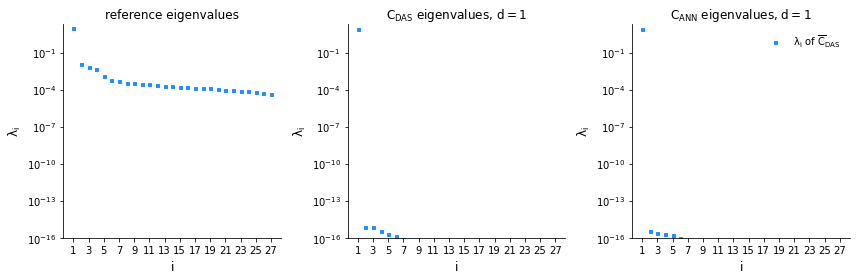

In [15]:
####################
# plot eigenvalues #
####################

fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(131, yscale='log', title='reference eigenvalues', ylim=[1e-16, 20])
ax.set_ylabel(r'$\lambda_i$', fontsize=12)
ax.set_xlabel(r'$i$', fontsize=12)
ax.plot(range(1, D + 1), eigvals_ref, 's', color='dodgerblue',  markersize=3,)
ax.set_xticks(np.arange(1, D + 1, 2))
#
ax2 = fig.add_subplot(132, yscale='log', title=r'%s eigenvalues, $d=%d$' % (r'$C_{DAS}$', d), ylim=[1e-16, 20])
ax2.set_ylabel(r'$\lambda_i$', fontsize=12)
ax2.set_xlabel(r'$i$', fontsize=12)
# ax2.plot(range(1, d + 1), eigvals_C_1, 'o', color='salmon', markersize=8, 
#          label = '%s of %s' % (r'$\lambda_i$', r'$\overline{C}_1$'))
ax2.plot(range(1, D + 1), eigvals_C_das, 's', color='dodgerblue', markersize=3,
         label='%s of %s' % (r'$\lambda_i$', r'$\overline{C}_{DAS}$'))
ax2.set_xticks(np.arange(1, D + 1, 2))
sns.despine(top=True)
#
ax3 = fig.add_subplot(133, yscale='log', title=r'%s eigenvalues, $d=%d$' % (r'$C_{ANN}$', d), ylim=[1e-16, 20])
ax3.set_ylabel(r'$\lambda_i$', fontsize=12)
ax3.set_xlabel(r'$i$', fontsize=12)
# ax2.plot(range(1, d + 1), eigvals_C_1, 'o', color='salmon', markersize=8, 
#          label = '%s of %s' % (r'$\lambda_i$', r'$\overline{C}_1$'))
ax3.plot(range(1, D + 1), eigvals_C_ann, 's', color='dodgerblue', markersize=3,
         label='%s of %s' % (r'$\lambda_i$', r'$\overline{C}_{DAS}$'))
ax3.set_xticks(np.arange(1, D + 1, 2))
sns.despine(top=True)
#
plt.legend(loc=0, frameon=False)
plt.tight_layout()

### Recreate the active subspace plot

In [16]:
#########################
# plot active subspaces #
#########################

# Generate new code validation samples
from HIV_model import *
n_val = 100
x_val = np.random.rand(n_val, D) * 2 - 1
val_samples = Tcells(x_val, np.linspace(1, times[I], times[I]))[:, -1]

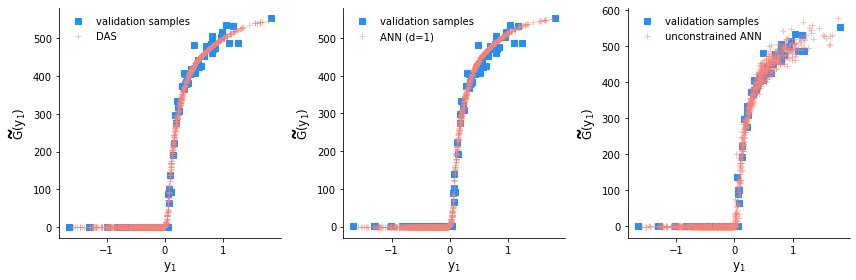

In [17]:
y_val = np.dot(W_1.T, x_val.T).T
y_val_ann = np.dot(V_1.T, x_val.T).T
y_val_ann_uc = np.dot(R_1.T, x_val.T).T

# plot DAS surrogate in y coordinate
fig = plt.figure(figsize=[12, 4])
ax = fig.add_subplot(131)
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(r'$\widetilde{G}\left(y_1\right)$', fontsize=12)
ax.plot(y_val, val_samples, 's', color='dodgerblue', label='validation samples') 
ax.plot(y_das, das_samples, '+', color='salmon', label='DAS', alpha=0.5)
leg = ax.legend(loc=0, frameon=False)
leg.set_draggable(True)
sns.despine(top=True)
plt.tight_layout()

# plot ANN surrogate in y coordinate
ax = fig.add_subplot(132)
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(r'$\widetilde{G}\left(y_1\right)$', fontsize=12)
ax.plot(y_val_ann, val_samples, 's', color='dodgerblue', label='validation samples') 
ax.plot(y_ann, ann_samples, '+', color='salmon', label='ANN (d=1)', alpha=0.5)
leg = ax.legend(loc=0, frameon=False)
leg.set_draggable(True)
sns.despine(top=True)
plt.tight_layout()

ax = fig.add_subplot(133)
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(r'$\widetilde{G}\left(y_1\right)$', fontsize=12)
ax.plot(y_val_ann_uc, val_samples, 's', color='dodgerblue', label='validation samples') 
ax.plot(y_ann_uc, ann_uc_samples, '+', color='salmon', label='unconstrained ANN', alpha=0.5)
leg = ax.legend(loc=0, frameon=False)
leg.set_draggable(True)
sns.despine(top=True)
plt.tight_layout()

### Plot the linear-regression active results

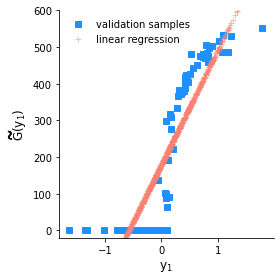

In [18]:
y_val_dirty = np.dot(w1_dirty.T, x_val.T).T
y_dirty = np.dot(w1_dirty.T, params.T).T
dirty_samples = np.dot(X_hat, a_hat)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111, ylim=[-20, 600])
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(r'$\widetilde{G}\left(y_1\right)$', fontsize=12)
ax.plot(y_val_dirty, val_samples, 's', color='dodgerblue', label='validation samples')
ax.plot(y_dirty, dirty_samples, '+', color='salmon', label='linear regression', alpha=0.5)
leg = ax.legend(loc=0, frameon=False)
leg.set_draggable(True)
sns.despine(top=True)
plt.tight_layout()
plt.savefig("foo.pdf")

### Recreate the C heat maps

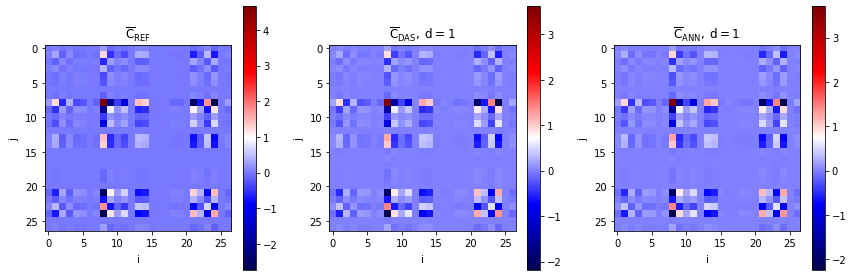

In [19]:
#####################################
# plot a heat map of the C matrices #
#####################################

fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(131, title=r'$\overline{C}_{REF}$', xlabel='$i$', ylabel='$j$')
im = ax1.imshow(C_ref)
plt.colorbar(im)
ax2 = fig.add_subplot(132, title=r'$\overline{C}_{DAS},\; d=%d$' % d, xlabel='$i$', ylabel='$j$')
im = ax2.imshow(C_das)
plt.colorbar(im)
ax3 = fig.add_subplot(133, title=r'$\overline{C}_{ANN},\; d=%d$' % d, xlabel='$i$', ylabel='$j$')
im = ax3.imshow(C_ann)
plt.colorbar(im)
plt.tight_layout()

### Recreate the global-derivative based sensitivity plots

In [20]:
def sensitivity(idx, V_i, **kwargs):
    # Parameter names
    param_names = np.array([r'$s_1$', r'$s_2$', r'$s_3$', r'$p_1$', r'$C_1$', r'$K_1$', r'$K_2$', r'$K_3$',
                   r'$K_4$', r'$K_5$', r'$K_6$', r'$K_7$', r'$K_8$', r'$K_9$', r'$K_{10}$',
                   r'$K_{11}$', r'$K_{12}$', r'$K_{13}$', r'$\delta_1$', r'$\delta_2$',
                   r'$\delta_3$', r'$\delta_4$', r'$\delta_5$', r'$\delta_6$', r'$\delta_7$', r'$\alpha_1$',
                   r'$\psi$'])
    
    fig = plt.figure(figsize=[4, 8])
    ax = fig.add_subplot(111, title=kwargs.get('title', ''))
    # ax.set_ylabel(r'$\int\left(\frac{\partial f}{\partial x_i}\right)^2 p({\bf x})d{\bf x}$', fontsize=14)
    ax.set_xlabel(r'$\nu_i$', fontsize=14)    
    ax.barh(range(V_i.size), width = V_i[idx].flatten(), color = 'dodgerblue')
    ax.set_yticks(range(V_i.size))
    ax.set_yticklabels(param_names[idx[0]], fontsize=14)
    # plt.xticks(rotation=90)
    ax.invert_yaxis()
    sns.despine(top=True)
    plt.tight_layout()

Creating DAS_analysis object
Creating ANN_analysis object
[ 0.01459843 -0.00788863 -0.03701837 -0.01337764 -0.02782644  0.0264299
  0.01299686 -0.01248487 -0.0005602   0.02968478 -0.01241041 -0.00324068
  0.00076574 -0.01593965  0.00965141 -0.0052904   0.01762609 -0.02341303
 -0.01204422 -0.03437637  0.02309029 -0.00039083  0.00212377 -0.00610452
  0.028341    0.01615835 -0.00536695]
Parameters ordered from most to least important:
[[ 8 24 21  9 23 13 14 11  1 22  2 10  3  4 26  5  0  7 18 19 15 16 20  6
  17 25 12]]
Parameters ordered from most to least important:
[[ 8 24 21  9 23 13 14  1 11 22  2 10  3  4  5 26  0  7 18 19 15 16 17  6
  12 25 20]]
Parameters ordered according to the reference activity score
[[ 8 24 21  9 23 13 14  1 11 22  2 10  3  4  5 26  0  7 18 19 15 20 16 17
  25  6 12]]


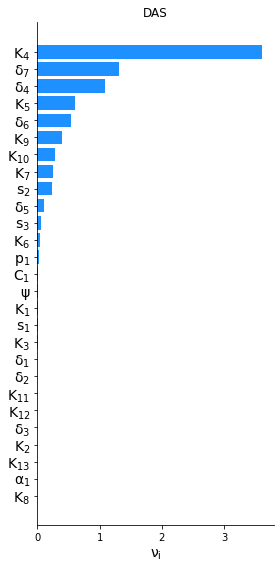

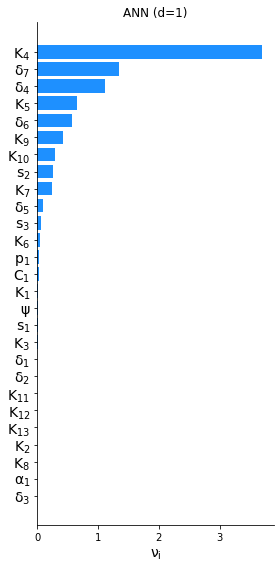

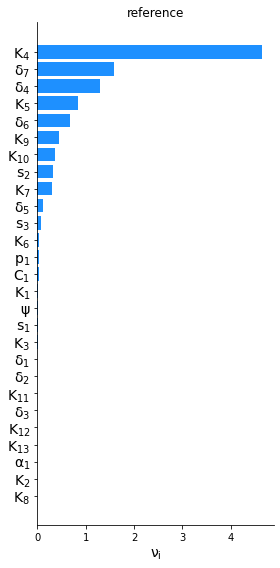

In [21]:
#####################################
# global gradient-based sensitivity #
#####################################

das_analysis = es.analysis.DAS_analysis(das_surrogate)
ann_analysis = es.analysis.ANN_analysis(ann_surrogate)

idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
sensitivity(idx, V_i, title = 'DAS')

idx, V_i = ann_analysis.sensitivity_measures(params, norm=False)
sensitivity(idx, V_i, title = 'ANN (d=1)')

print('Parameters ordered according to the reference activity score')
V_i_ref = np.diag(C_ref)
idx_ref = np.flipud(np.argsort(np.diag(C_ref))).reshape([1, -1])
print(idx_ref)
sensitivity(idx_ref, V_i_ref, title='reference')

### Error analysis

The errors were computed using 100 replica networks, which takes a long time (several hours). The errors are therefore loaded from memory using the files `errors_n_neurons100.hdf5` or  `errors_n_neurons10.hdf5`, corresponding to the case of 10 or 100 neurons per hidden layer.

We also include the data with 100 neurons, and $d=2$ in `errors_n_neurons100_d2.hdf5`.

If you still wish to recompute the errors, execute `recompute_HIV_errors.py`. Note that it is possible that (1 or 2) outliers are present, where one of the replica neural networks did not converge properly. We removed these from the HDF5 files.

In [22]:
def get_error_CI(err):
    mean_err = np.mean(err, axis=0)
    lower, upper = analysis.get_confidence_intervals(err, conf=conf)
    err = np.array([mean_err - lower, upper - mean_err])

    return mean_err, err

Loaded err_ANN
Loaded err_ANN_unconstrained
Loaded err_DAS


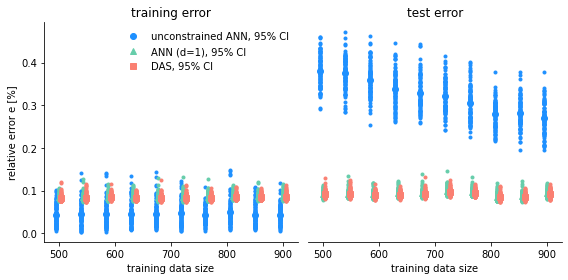

In [25]:
# number of neurons, replicas and tra
n_test_fracs = 10

test_fracs = np.linspace(0.5, 0.1, n_test_fracs)

# 10 neurons, d=1
#file = 'errors_n_neurons10.hdf5'
# 100 neurons, d=1
file = 'errors_n_neurons100.hdf5'
# 100 neurons, d=2
#file = 'errors_n_neurons100_d2.hdf5'

errors = campaign.load_hdf5_data(file_path=file)
err_ANN_unconstrained = errors['err_ANN_unconstrained']
err_ANN = errors['err_ANN']
err_DAS = errors['err_DAS']

# trun into percentage
err_ANN *= 100
err_DAS *= 100
err_ANN_unconstrained *= 100
# select confidence
conf = 0.95
# size of training data used
data_size = (1 - test_fracs) * samples.shape[0]
# mean and CI of ANN training error
analysis = es.analysis.BaseAnalysis()

mean_ANN_err_training, err_ANN_training = get_error_CI(err_ANN[:,:,0])
mean_DAS_err_training, err_DAS_training = get_error_CI(err_DAS[:,:,0])
mean_ANN_unconstrained_training, err_ANN_unconstrained_training = get_error_CI(err_ANN_unconstrained[:,:,0])

mean_ANN_err_test, err_ANN_test = get_error_CI(err_ANN[:,:,1])
mean_DAS_err_test, err_DAS_test = get_error_CI(err_DAS[:,:,1])
mean_ANN_unconstrained_test, err_ANN_unconstrained_test = get_error_CI(err_ANN_unconstrained[:,:,1])

# plot results
import seaborn as sns
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(121)
ax.set_xlabel('training data size')
ax.set_ylabel('relative error e [%]')
ax.set_title('training error')
sns.despine(top=True)
offset=5

# make the CI plots
#ax.errorbar(data_size-offset, mean_ANN_unconstrained_training, 
#            yerr=err_ANN_unconstrained_training, fmt='o', color='dodgerblue', label='unconstrained ANN, 95% CI')
#ax.errorbar(data_size, mean_ANN_err_training, yerr=err_ANN_training, fmt='^', 
#            color='mediumaquamarine', label='ANN (d=1), 95% CI')
#ax.errorbar(data_size+offset, mean_DAS_err_training, yerr=err_DAS_training, fmt='s', 
#            color='salmon', label='DAS, 95% CI')

# make the plot using all samples, not with confidence intervals
ax.plot(data_size-offset, mean_ANN_unconstrained_training, 'o', color='dodgerblue',
        label='unconstrained ANN, 95% CI')
ax.plot(data_size-offset, err_ANN_unconstrained[:,:,0].T, '.', color='dodgerblue')

ax.plot(data_size, mean_ANN_err_training, '^', color='mediumaquamarine',
        label='ANN (d=1), 95% CI')
ax.plot(data_size, err_ANN[:,:,0].T, '.', color='mediumaquamarine')

ax.plot(data_size+offset, mean_DAS_err_training, 's', color='salmon', label='DAS, 95% CI')
ax.plot(data_size+offset, err_DAS[:,:,0].T, '.', color='salmon')

leg = ax.legend(loc=0, frameon=False)
#
ax2 = fig.add_subplot(122, sharey=ax)
ax2.set_xlabel('training data size')
ax2.set_title('test error')

# make the CI plots
#ax2.errorbar(data_size, mean_ANN_err_test, yerr=err_ANN_test, fmt='^', color='mediumaquamarine')
#ax2.errorbar(data_size+offset, mean_DAS_err_test, yerr=err_DAS_test, fmt='s', color='salmon')
#ax2.errorbar(data_size-offset, mean_ANN_unconstrained_test, yerr=err_ANN_unconstrained_test,
#             fmt='o', color='dodgerblue')

# make the plot using all samples, not with confidence intervals
ax2.plot(data_size, mean_ANN_err_test, '^', color='mediumaquamarine')
ax2.plot(data_size, err_ANN[:,:,1].T, '.', color='mediumaquamarine')

ax2.plot(data_size+offset, mean_DAS_err_test, 's', color='salmon')
ax2.plot(data_size+offset, err_DAS[:,:,1].T, '.', color='salmon')

ax2.plot(data_size-offset, mean_ANN_unconstrained_test, 'o', color='dodgerblue')
ax2.plot(data_size-offset, err_ANN_unconstrained[:,:,1].T, '.', color='dodgerblue')

sns.despine(left=True, ax=ax2)
ax2.get_yaxis().set_visible(False)
plt.tight_layout()
